# Thompson Sampling

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [2]:
"""
Plot functions
"""
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

#sns.set_style("darkgrid", {"axes.facecolor": ".9"})


def plot_cum_rewards(rewards_list, probs, names):
    rounds = np.array(range(len(rewards_list[0])))+1
    optimal = rounds * np.max(probs)

    plt.plot(rounds, optimal, label = "Optimal action")
    for reward, name in zip(rewards_list, names):
        plt.plot(rounds,reward, label = name)
        
    plt.grid()
    plt.legend()
    plt.title("Average cumulative rewards", fontsize=20)
    plt.xlabel("Rounds", fontsize=18)
    plt.ylabel("Reward", fontsize=18)
    plt.savefig("rewards")
    plt.show()


def plot_regret(rewards_list, probs, names):
    reward_optimal = np.max(probs)
    rounds = range(len(rewards_list[0][0]))

    for reward, name in zip(rewards_list, names):
        #print(np.mean(reward, axis = 0))
        regret = reward_optimal - np.sum(reward, axis = 0)
        plt.plot(rounds, regret, label = name)
    
    plt.grid()
    plt.legend()
    plt.title("Regret", fontsize=20)
    plt.xlabel("Rounds", fontsize=18)
    plt.ylabel("Regret", fontsize=18)
    plt.savefig("regret")
    plt.show()

def plot_probability(average_actions, method, fn=''):
    rounds = range(len(average_actions[0]))

    for i, action in enumerate(average_actions):
        plt.plot(rounds, action, label = i)

    plt.grid()
    plt.legend()
    plt.title(f"Probability of actions with {method}", fontsize=20)
    plt.xlabel("Rounds", fontsize=18)
    plt.ylabel("Probability", fontsize=18)
    plt.ylim(0,1)
    plt.savefig(f"probability_{fn}")
    plt.tight_layout()
    plt.show()

def plot_pdf(params,names):
    pass

# Bernoulli Bandit Problem

In [3]:
"""
Class for doing the Thompson Sampling algorithm for Bernoulli Bandits problems.
Without any other information the class will assume a uniform prior for all arms,
and the theats values will be choosen randomly. 
The theta values can be overwritten by calling the overwrite_thetas function and give the specific values.
"""
class BernoulliBanditsTS():
    def __init__(self, a0 = 1, b0 = 1, n_arms = 3, epsilon = 0.0):

        self.n_arms = n_arms
        self.epsilon = epsilon
        self.alpha = np.array([a0 for i in range(n_arms)])
        self.beta = np.array([b0 for i in range(n_arms)])

        self.thetas = np.random.uniform(size = n_arms)
        self.optimal_action = np.argmax(self.thetas)
        
    
    #Function for giving our own theta values.
    def overwrite_thetas(self, probs):
        try:
            self.thetas = np.array(probs)
            self.optimal_action = np.argmax(self.thetas)
        except:
            print("Input argument must be list of length", self.n_arms)
   
    #This function draws a random value from all the posterior distributions.
    def get_posterior_sample(self):
        return np.random.beta(self.alpha, self.beta)

    #This function finds the mean of all the posterior distributions.
    def get_posterior_mean(self):
        return self.alpha / (self.alpha + self.beta)

    #Function for picking an action after sampling from all the distributions.
    def pick_action(self):
        samples = self.get_posterior_sample()
        action = self.random_argmax(samples)
        return action

    #Function for picking a random index from the set of all the maxium values in the list
    def random_argmax(self,samples):
        return np.random.choice(np.where(samples == np.max(samples))[0])

    #Get the reward given an action
    def get_reward(self, action):
        if np.random.uniform() < self.thetas[action]:
            self.alpha[action] += 1
            return 1
        else:
            self.beta[action] += 1
            return 0

    #Function for running an experiment for n_rounds rounds.
    def run_experiment(self, n_rounds):
        #Arrays for storing the rewards, action, and total_reward
        rewards = np.zeros((self.n_arms, n_rounds))
        actions = np.zeros((self.n_arms, n_rounds))
        total_reward = np.zeros(n_rounds)
        
        action = self.pick_action() #Pick action
        reward = self.get_reward(action) #Get reward
        rewards[action,0] = reward #Store reward
        total_reward[0] = reward #Store total reward
        actions[action,0] = 1 #Store the action taken
        #Loop through the number of rounds -1
        for i in range(1,n_rounds):
            action = self.pick_action() #Pick action
            reward = self.get_reward(action) #Get reward
            rewards[action,i] = reward #Store reward
            total_reward[i] = reward + total_reward[i-1] #Store total reward
            actions[action,i] = 1 #Store the action taken

        return rewards, total_reward, actions
    
    #Function for running multiple simulations of the same problem.
    def run_simulation(self, n_sims, n_rounds):
        #Arrays for storing average results
        average_actions = np.zeros((self.n_arms, n_rounds))
        average_rewards = np.zeros((self.n_arms, n_rounds))
        average_total_rewards = np.zeros(n_rounds)

        for i in range(n_sims):
            #Define priors (uniform)
            self.alpha = np.array([1 for i in range(self.n_arms)])
            self.beta = np.array([1 for i in range(self.n_arms)])
            
            #Run each simulation
            rewards, total_rewards, actions = self.run_experiment(n_rounds)

            average_rewards += rewards
            average_total_rewards += total_rewards
            average_actions += actions

        average_rewards /= n_sims
        average_total_rewards /= n_sims
        average_actions /= n_sims

        return average_rewards, average_total_rewards, average_actions


"""
Class for doing the epsilon-greedy algorithm for the Bernoulli Bandits problem. 
This class uses the Thompson Sampling class, but instead of sampling from the distributions
it only looks at the mean of the distributions (the mean are the number of sucesses+1 over the total number of tries+2).
"""
class BernoulliBanditsEpsilonGreedy(BernoulliBanditsTS):
    def __init__(self, alpha = 1, beta = 1, n_arms = 3, epsilon = 0.0):
        BernoulliBanditsTS.__init__(self, a0 = alpha, b0 = beta, n_arms = n_arms, epsilon = epsilon)

    #Overwrite the pick_action function in the Thompson Sampling class
    def pick_action(self):
        samples = self.get_posterior_mean()

        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,self.n_arms-1)
        
        else:
            action = self.random_argmax(samples)

        return action
        


In [4]:
def simulation(n_arms, n_sims, n_rounds):
    probs = [0.9, 0.8, 0.7, 0.6, 0.5]
    #probs = np.random.uniform(size=n_arms)
    n_arms = len(probs)
    print(probs)

    
    TS = BernoulliBanditsTS(n_arms = n_arms)
    TS.overwrite_thetas(probs)
    TS_average_rewards, TS_average_total_rewards, TS_average_actions = TS.run_simulation(n_sims, n_rounds)

    eps = 0.2
    eG = BernoulliBanditsEpsilonGreedy(n_arms = n_arms, epsilon = eps)
    eG.overwrite_thetas(probs)
    eG_average_rewards, eG_average_total_rewards, eG_average_actions = eG.run_simulation(n_sims, n_rounds)

    G = BernoulliBanditsEpsilonGreedy(n_arms = n_arms, epsilon = 0.0)
    G.overwrite_thetas(probs)
    G_average_rewards, G_average_total_rewards, G_average_actions = G.run_simulation(n_sims, n_rounds)

    total_rewards_list = [TS_average_total_rewards, eG_average_total_rewards, G_average_total_rewards]
    names = ["Thompson Sampling", f"$\epsilon$-Greedy $\epsilon={eps}$", "$\epsilon$-Greedy $\epsilon=0$"]
    
    plot_cum_rewards(total_rewards_list, probs, names)

    average_rewards_list = [TS_average_rewards, eG_average_rewards, G_average_rewards]

    plot_regret(average_rewards_list, probs, names)

    plot_probability(TS_average_actions, "Thompson Sampling", "TS")
    plot_probability(eG_average_actions, f"$\epsilon$-Greedy $\epsilon={eps}$", "eG02")
    plot_probability(G_average_actions, "Greedy", "Greedy")



[0.9, 0.8, 0.7, 0.6, 0.5]


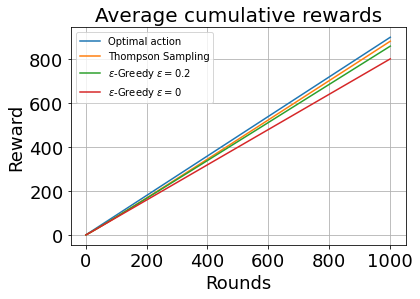

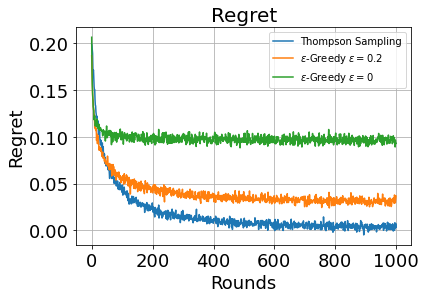

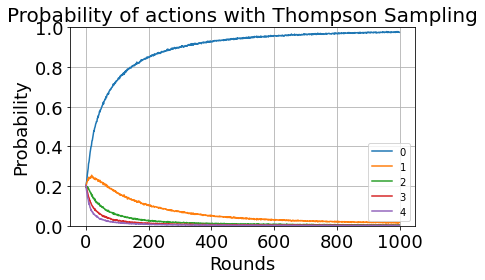

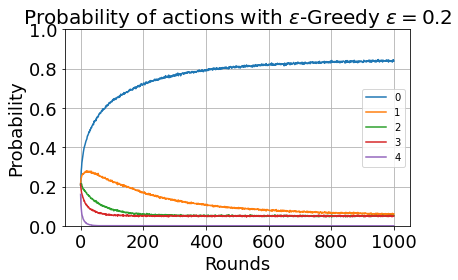

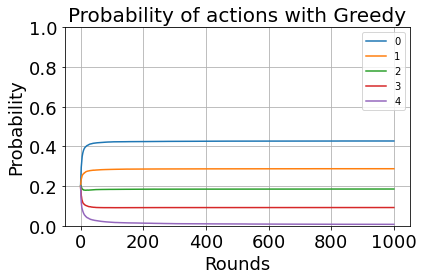

In [5]:
simulation(5, n_sims = 15000, n_rounds = 1000)

# Shortest Path Problem

In [2]:
import sys
 
class Graph(object):
    def __init__(self, nodes, init_graph):
        self.nodes = nodes
        self.graph = init_graph
        #self.graph = self.construct_graph(nodes, init_graph)
        
    def construct_graph(self, nodes, init_graph):
        '''
        This method makes sure that the graph is symmetrical. 
        In other words, if there's a path from node A to B with a value V, 
        there needs to be a path from node B to node A with a value V.
        '''
        graph = {}
        for node in nodes:
            graph[node] = {}
        
        graph.update(init_graph)
        
        for node, edges in graph.items():
            for adjacent_node, value in edges.items():
                if graph[adjacent_node].get(node, False) == False:
                    graph[adjacent_node][node] = value
                    
        return graph
    
    def get_nodes(self):
        "Returns the nodes of the graph."
        return self.nodes
    
    def get_outgoing_edges(self, node):
        "Returns the neighbors of a node."
        connections = []
        for out_node in self.nodes:
            if self.graph[node].get(out_node, False) != False:
                connections.append(out_node)
        return connections
    
    def value(self, node1, node2):
        "Returns the value of an edge between two nodes."
        return self.graph[node1][node2]

def dijkstra_algorithm(graph, start_node):
    unvisited_nodes = list(graph.get_nodes())
 
    # We'll use this dict to save the cost of visiting each node and update it as we move along the graph   
    shortest_path = {}
 
    # We'll use this dict to save the shortest known path to a node found so far
    previous_nodes = {}
 
    # We'll use max_value to initialize the "infinity" value of the unvisited nodes   
    max_value = sys.maxsize
    for node in unvisited_nodes:
        shortest_path[node] = max_value
    # However, we initialize the starting node's value with 0   
    shortest_path[start_node] = 0
    
    # The algorithm executes until we visit all nodes
    while unvisited_nodes:
        # The code block below finds the node with the lowest score
        current_min_node = None
        for node in unvisited_nodes: # Iterate over the nodes
            if current_min_node == None:
                current_min_node = node
            elif shortest_path[node] < shortest_path[current_min_node]:
                current_min_node = node
                
        # The code block below retrieves the current node's neighbors and updates their distances
        neighbors = graph.get_outgoing_edges(current_min_node)
        for neighbor in neighbors:
            tentative_value = shortest_path[current_min_node] + graph.value(current_min_node, neighbor)
            if tentative_value < shortest_path[neighbor]:
                shortest_path[neighbor] = tentative_value
                # We also update the best path to the current node
                previous_nodes[neighbor] = current_min_node
 
        # After visiting its neighbors, we mark the node as "visited"
        unvisited_nodes.remove(current_min_node)
    
    return previous_nodes, shortest_path

def find_best_path(previous_nodes, shortest_path, start_node, target_node):
    path = []
    node = target_node
    
    while node != start_node:
        path.append(node)
        node = previous_nodes[node]
 
    # Add the start node manually
    path.append(start_node)  
    
    return list(reversed(path))
  
    
def update_normal(mu, sigma2, n, s):
    #new_mu = (mu/sigma2 + np.log(obs)+1/2)/(1/sigma2 + 1)
    #new_sigma2 = 1/(1/sigma2 + 1)
    new_sigma2 = 1/(1/100**2 + n)
    new_mu = new_sigma2*s
    return new_mu, new_sigma2


def ShortestPathTS(graph, start_node, end_node, prior, correct_values, n_rounds, n_s):
    regret = []
    n_best = 0
    for r in range(n_rounds):
        for i in graph.graph.keys():
            for j in graph.graph[i].keys():
                graph.graph[i][j] = np.random.normal(prior[f"{i},{j}"][0], prior[f"{i},{j}"][1])
                #print(f"{i}, {j}: {graph.graph[i][j]}")
        previous_nodes, shortest_path = dijkstra_algorithm(graph, start_node)
        path = find_best_path(previous_nodes, shortest_path, start_node, end_node)
        
        if path == [0,3,5,7,8,10]:
            n_best += 1
        #if r == n_rounds-1:
            #print(path)
            #for h in range(len(path)-1):
                #print(graph.graph[path[h]][path[h+1]])
        res = 0
        for e in range(len(path)-1):
            edge = f"{path[e]},{path[e+1]}"
            obs = np.random.normal(correct_values[edge][0], correct_values[edge][1])
            n_s[edge][0] += 1
            n_s[edge][1] += obs
            #print(f"obs: {obs}")
            res += obs
            prior[edge][0], prior[edge][1] = update_normal(prior[edge][0], prior[edge][1], n_s[edge][0], n_s[edge][1])
        regret.append(res-12)
    print(n_best)
    return prior, regret


nodes = [0,1,2,3,4,5,6,7,8,9,10]
 
init_graph = {}
for node in nodes:
    init_graph[node] = {}
    
init_graph[0][1] = 9
init_graph[0][2] = 4
init_graph[0][3] = 7
init_graph[1][4] = 6
init_graph[1][5] = 2
init_graph[2][4] = 9
init_graph[2][6] = 7
init_graph[3][5] = 1
init_graph[3][6] = 11
init_graph[4][7] = 7
init_graph[5][7] = 4
init_graph[6][7] = 5
init_graph[7][8] = 2
init_graph[7][9] = 5
init_graph[8][10] = 4
init_graph[9][10] = 3


graph = Graph(nodes, init_graph)


prior = {}
n_s = {}
correct_values = {}
for i in graph.graph.keys():
    for j in graph.graph[i].keys():
        correct_values[f"{i},{j}"] = [graph.graph[i][j], 1]
        prior[f"{i},{j}"] = [0, 100]
        n_s[f"{i},{j}"] = [0, 0]


p,r = ShortestPathTS(graph, 0, 10, prior, correct_values, 1000, n_s)
     
"""
a_r = np.zeros(1000)
for i in range(1000):
    if i % 100 == 0:
        print(i)
    p,r = ShortestPathTS(graph, 0, 10, prior, correct_values, 1000, n_s)
    a_r += r
a_r /= 1000
#print(p)
plt.plot(a_r)
plt.show()
"""

994


'\na_r = np.zeros(1000)\nfor i in range(1000):\n    if i % 100 == 0:\n        print(i)\n    p,r = ShortestPathTS(graph, 0, 10, prior, correct_values, 1000, n_s)\n    a_r += r\na_r /= 1000\n#print(p)\nplt.plot(a_r)\nplt.show()\n'

In [ ]:
np.random.normal(0, 100, 100)